In [1]:
# packages
import pandas as pd
import camelot
import PyPDF2
import glob
import re
import os
import duckdb 
import numpy as np
from dtype_dictionaries import create_dtype_dict

In [2]:
def transform_month(match):
    month_abbreviations = {
        "January": "01",
        "February": "02",
        "March": "03",
        "April": "04",
        "May": "05",
        "June": "06",
        "July": "07",
        "August": "08",
        "September": "09",
        "October": "10",
        "November": "11",
        "December": "12"
    }
    # Get the month abbreviation from the match
    month_abbrev = match.group(3)
    # Use the abbreviation to look up the full month name
    full_month = month_abbreviations.get(month_abbrev, month_abbrev)
    return f"{match.group(5)}-{full_month}-{match.group(1)}"

def parse_date(page_text): 
    # The top of the page is always:  "Daily Weather Summary for Sunday 01 January 2023 \n".
    pre_index = page_text.find('day') + 3 # we cant be sure that the pdf if correctly read 100% so this should be quite generic
    post_index = page_text.find('Selected')
    # Get the date between the two token variables and add to the df
    date = re.sub(r'[^a-zA-Z0-9]', '', page_text[pre_index:post_index]) 
    formatted_date = re.sub(r'(\d{1,2})(\s*)([A-Za-z]+)(\s*)(\d{3,4})', transform_month, date) # make sure to format the date correctly for
    midnight = formatted_date + "T00:00"
    noon = formatted_date + "T12:00"
    print(midnight)
    return np.datetime64(midnight), np.datetime64(noon)

def process_met_pdf(file_path):
    dtype_dict, _ = create_dtype_dict(file_path)

    # This is the text at the top of the page where the weather tables are. We use it to know which pages we want to read
    search_string = 'Selected UK readings at (L) 0000 and (R) 1200 UTC'
    pattern = re.compile(r'\s*'.join(re.escape(word) for word in search_string.split())) # the whitespace can be read incorrectly so we allow for optional whitespace
    # This is the columns without the date. When we need the date we append it with ['Date'] + columns
    columns = ['Date', 'Station_no', 'Station_name', 'PRESS', 'WDIR', 'WSPD', 'CLOUD', 'TEMP', 'TDEW']
    df_dtypes = {'Date': "datetime64[s]", 'Station_no': int, 'Station_name': str, 'PRESS': float, 'WDIR': str, 'WSPD': float, 'CLOUD': float, 'TEMP': float, 'TDEW': float}
    #         '1200_PRESS', '1200_WDIR', '1200_WSPD', '1200_CLOUD', '1200_TEMP', '1200_TDEW']

    with open(file_path, 'rb') as pdf_raw:
        pdf = PyPDF2.PdfReader(pdf_raw)
        print(len(pdf.pages))

        df = pd.DataFrame(dtype_dict)
        i = 0
        while i < len(pdf.pages):
            page_text = pdf.pages[i].extract_text()
            if re.search(pattern, page_text):
                table = camelot.read_pdf(file_path, pages=str(i + 1))

                table_df = table[0].df
                table_df = table_df.iloc[2:] # cut of the header of the table
                
                midnight_df = table_df.iloc[:,0:8]
                noon_columns = table_df.columns[:2].union(table_df.columns[8:])
                noon_df = table_df[noon_columns]

                midnight_date, noon_date = parse_date(page_text)
                
                midnight_df.insert(0, "Date", midnight_date)
                midnight_df = midnight_df.replace("-", np.nan)
                midnight_df.columns = columns
                midnight_df = midnight_df.astype(df_dtypes)
                
                noon_df.insert(0, "Date", noon_date)
                noon_df = noon_df.replace("-", np.nan)
                noon_df.columns = columns
                noon_df = noon_df.astype(df_dtypes)
                
                df = pd.concat([df, midnight_df, noon_df], ignore_index=True)
                i += 6
            i += 1
    return df
        

In [3]:
def get_tables(conn):
    tables_lists = conn.sql("SHOW TABLES").fetchall()
    return [t[0] for t in tables_lists]

def table_exists(table_name, conn):
    return table_name in get_tables(conn)

In [12]:
data_path="../data/landing/persistent/*"
# connect to the formatted zone database
conn = duckdb.connect('../data/formatted_zone/formatted_zone.db')

for file in glob.glob(data_path): 
    base_name = os.path.basename(file) # Get last part of the filepath
    table_name = os.path.splitext(base_name)[0] # Remove the extension if there is one
    if table_exists(table_name, conn):
        continue
    print(f"Processing: {table_name}")
    # only move .csv and .pdf files to a table
    if file.split(".")[-1] == "csv":
        dtype_dict, date_columns = create_dtype_dict(table_name)
        df = pd.read_csv(file, dtype=dtype_dict, parse_dates=date_columns)
                
        conn.sql(f"CREATE TABLE \"{table_name}\" AS SELECT * FROM df")
        
    if file.split(".")[-1] == "pdf": 
        # this will create a new table per pdf file
        df = process_met_pdf(file)
        
        conn.sql(f"CREATE TABLE \"{table_name}\" AS SELECT * FROM df")

        
# close the connection
conn.close()

Processing: Metoffice_05_22_2023-09-22
../data/landing/persistent/Metoffice_05_22_2023-09-22.pdf
223
2022-05-01T00:00
2022-05-02T00:00
2022-05-03T00:00
2022-05-04T00:00
2022-05-05T00:00
2022-05-06T00:00
2022-05-07T00:00
2022-05-08T00:00
2022-05-09T00:00
2022-05-10T00:00
2022-05-11T00:00
2022-05-12T00:00
2022-05-13T00:00
2022-05-14T00:00
2022-05-15T00:00
2022-05-16T00:00
2022-05-17T00:00
2022-05-18T00:00
2022-05-19T00:00
2022-05-20T00:00
2022-05-21T00:00
2022-05-22T00:00
2022-05-23T00:00
2022-05-24T00:00
2022-05-25T00:00
2022-05-26T00:00
2022-05-27T00:00
2022-05-28T00:00
2022-05-29T00:00
2022-05-30T00:00
2022-05-31T00:00
Processing: Metoffice_01_23_2023-09-22
../data/landing/persistent/Metoffice_01_23_2023-09-22.pdf
255
2023-01-01T00:00
2023-01-02T00:00
2023-01-03T00:00
2023-01-04T00:00
2023-01-05T00:00
2023-01-06T00:00
2023-01-07T00:00
2023-01-08T00:00
2023-01-09T00:00
2023-01-10T00:00
2023-01-11T00:00
2023-01-12T00:00
2023-01-13T00:00
2023-01-14T00:00
2023-01-15T00:00
2023-01-16T00:00

2023-07-07T00:00
2023-07-08T00:00
2023-07-09T00:00
2023-07-10T00:00
2023-07-11T00:00
2023-07-12T00:00
2023-07-13T00:00
2023-07-14T00:00
2023-07-15T00:00
2023-07-16T00:00
2023-07-17T00:00
2023-07-18T00:00
2023-07-19T00:00
2023-07-20T00:00
2023-07-21T00:00
2023-07-22T00:00
2023-07-23T00:00
2023-07-24T00:00
2023-07-25T00:00
2023-07-26T00:00
2023-07-27T00:00
2023-07-28T00:00
2023-07-29T00:00
2023-07-30T00:00
2023-07-31T00:00
Processing: README
Processing: Metoffice_12_22_2023-09-22
../data/landing/persistent/Metoffice_12_22_2023-09-22.pdf
254
2022-12-01T00:00
2022-12-02T00:00
2022-12-03T00:00
2022-12-04T00:00
2022-12-05T00:00
2022-12-06T00:00
2022-12-07T00:00
2022-12-08T00:00
2022-12-09T00:00
2022-12-10T00:00
2022-12-11T00:00
2022-12-12T00:00
2022-12-13T00:00
2022-12-14T00:00
2022-12-15T00:00
2022-12-16T00:00
2022-12-17T00:00
2022-12-18T00:00
2022-12-19T00:00
2022-12-20T00:00
2022-12-21T00:00
2022-12-22T00:00
2022-12-23T00:00
2022-12-24T00:00
2022-12-25T00:00
2022-12-26T00:00
2022-12-27T00

In [13]:
# CHECK THE TABLES ON THE DB
conn = duckdb.connect('../data/formatted_zone/formatted_zone.db')
tables = get_tables(conn)
for table_name in tables: 
    print(table_name)
    df = conn.sql(f"SELECT * FROM \"{table_name}\";").df()
    print(df.describe())
conn.close()

Metoffice_01_22_2023-09-22
        Station_no        PRESS         WSPD        CLOUD         TEMP         TDEW
count  2170.000000  2151.000000  2083.000000  2148.000000  2163.000000  2164.000000
mean     18.000000  1022.177127    10.176188     5.257914     5.872076     3.363078
std      10.101833    14.300195     6.770647     3.299879     3.199356     3.317373
min       1.000000   981.500000     0.000000     0.000000    -6.700000    -7.800000
25%       9.000000  1011.450000     5.000000     1.000000     3.800000     1.100000
50%      18.000000  1026.100000     9.000000     7.000000     6.000000     3.100000
75%      27.000000  1034.100000    14.000000     8.000000     8.000000     5.600000
max      35.000000  1043.200000    40.000000     9.000000    15.100000    12.200000
Metoffice_01_23_2023-09-22
        Station_no        PRESS         WSPD        CLOUD         TEMP         TDEW
count  2170.000000  2120.000000  2013.000000  2112.000000  2144.000000  2145.000000
mean     18.000000  10

        Station_no        PRESS         WSPD        CLOUD         TEMP         TDEW
count  2170.000000  2135.000000  2087.000000  2126.000000  2088.000000  2088.000000
mean     18.000000  1017.600094     7.409200     4.721072    16.979358    11.987883
std      10.101833     7.462318     4.347807     3.489116     4.506247     2.984117
min       1.000000   994.500000     0.000000     0.000000     3.400000     2.400000
25%       9.000000  1012.350000     4.000000     0.000000    14.000000    10.100000
50%      18.000000  1018.000000     7.000000     7.000000    16.500000    12.100000
75%      27.000000  1023.500000    10.000000     8.000000    19.625000    14.000000
max      35.000000  1031.800000    32.000000     9.000000    32.900000    19.300000
Metoffice_08_23_2023-09-22
        Station_no        PRESS         WSPD        CLOUD         TEMP         TDEW
count  2170.000000  2166.000000  2105.000000  2148.000000  2063.000000  2063.000000
mean     18.000000  1012.103555     8.666033     

             FTHG        FTAG        HTHG        HTAG          HS          AS         HST         AST          HF          AF          HC          AC          HY          AY          HR          AR       B365H       B365D       B365A         BWH         BWD         BWA         IWH         IWD         IWA         PSH         PSD         PSA         WHH         WHD         WHA         VCH         VCD         VCA        MaxH        MaxD        MaxA        AvgH        AvgD        AvgA    B365>2.5  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000  

In [ ]:
# CONVERT Metdata to correct datatypes. Only needed because Jóhannes forgot to when processing pdfs initially
# df_dtypes = {'Date': "datetime64[s]", 'Station_no': int, 'Station_name': str, 'PRESS': float, 'WDIR': str, 'WSPD': float, 'CLOUD': float, 'TEMP': float, 'TDEW': float}
# conn = sqlite3.connect('../data/formatted_zone/formatted_zone.db')
# c = conn.cursor()
# c.execute("SELECT name FROM sqlite_master WHERE type='table';")
# tables = c.fetchall()
# for table in tables: 
#     table_name = table[0]
#     if 'Metoffice' not in table_name: continue
#     print(table_name)
#     dtype_dict, date_columns = create_dtype_dict(table_name)
#     df = pd.read_sql_query(f"SELECT * FROM \"{table_name}\";", conn, parse_dates=date_columns)
#     df = df.astype(df_dtypes)
#     df.to_sql(table_name, con=conn, if_exists='replace', index=False)
# conn.close()


In [14]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


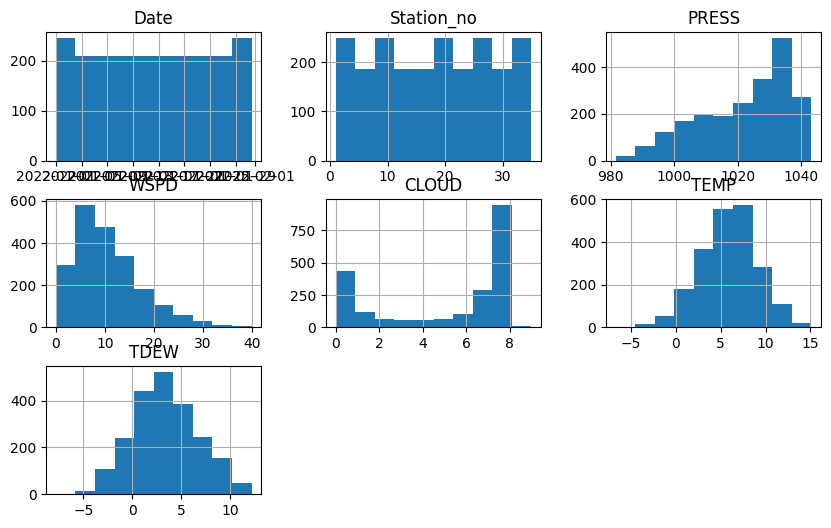

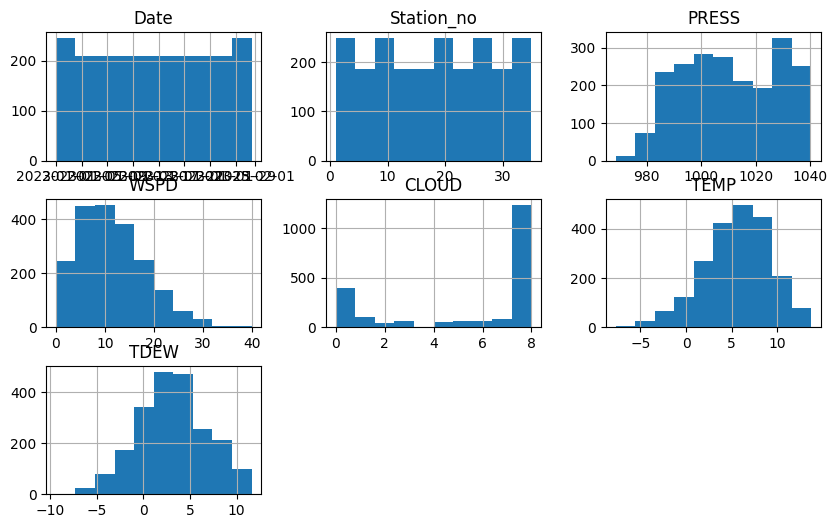

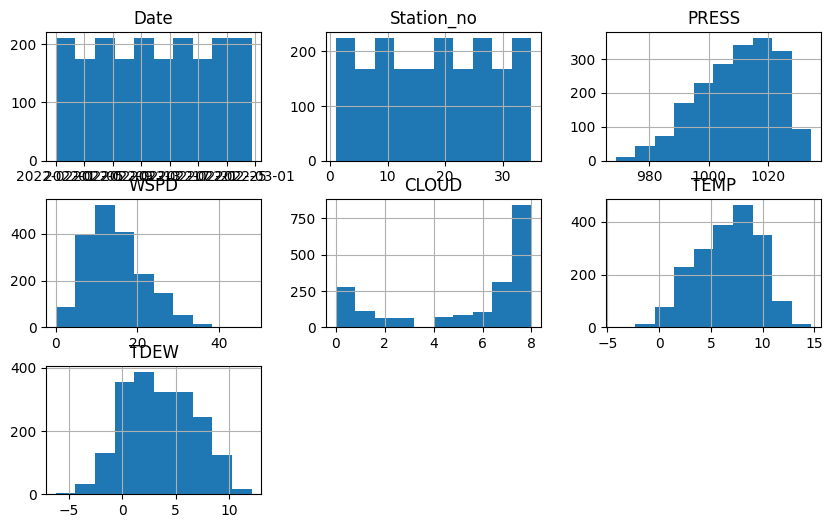

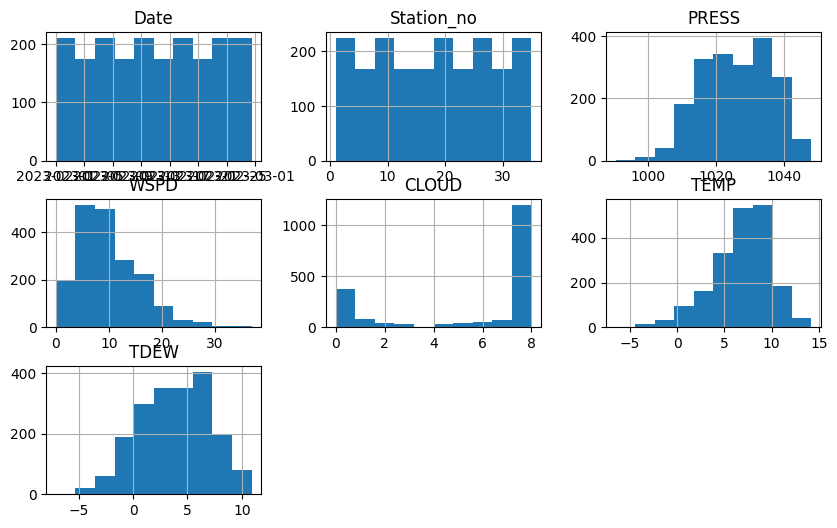

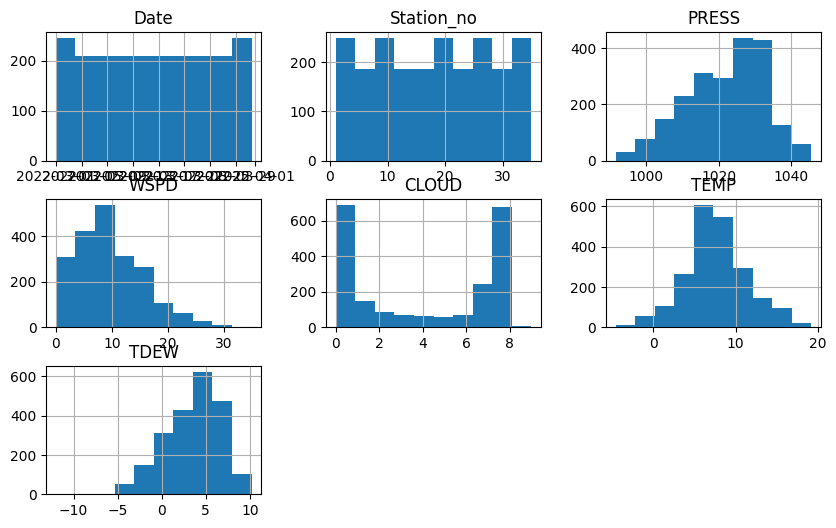

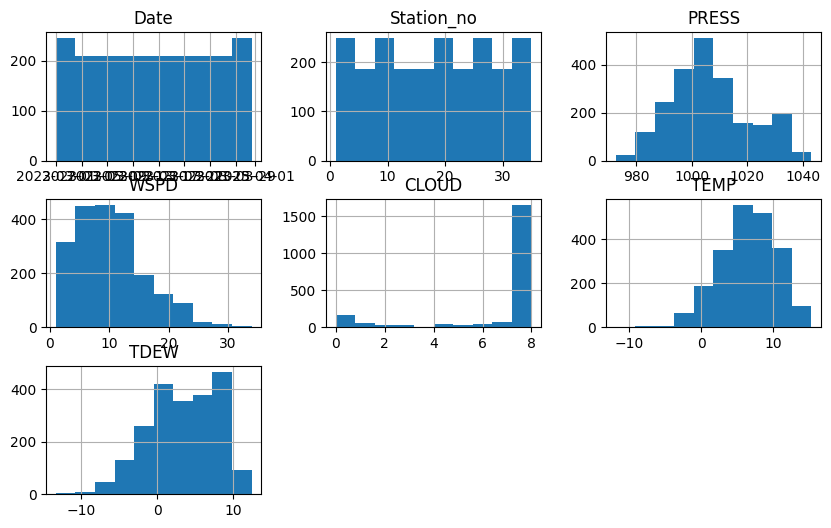

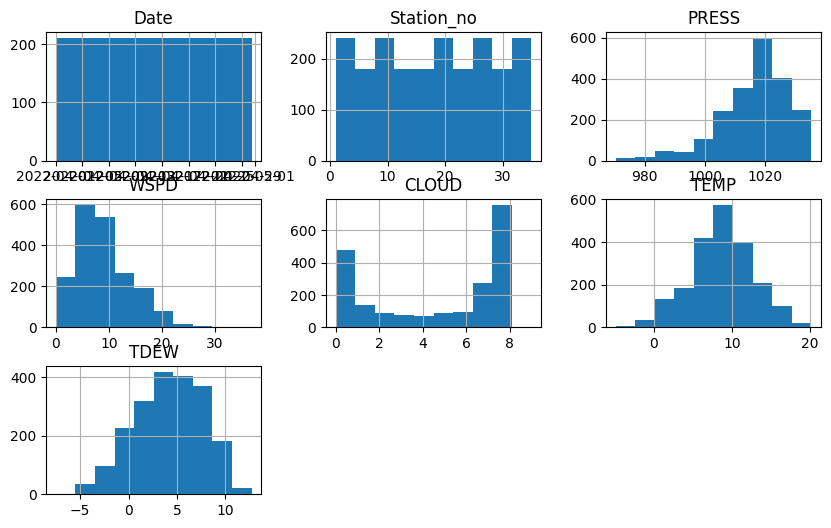

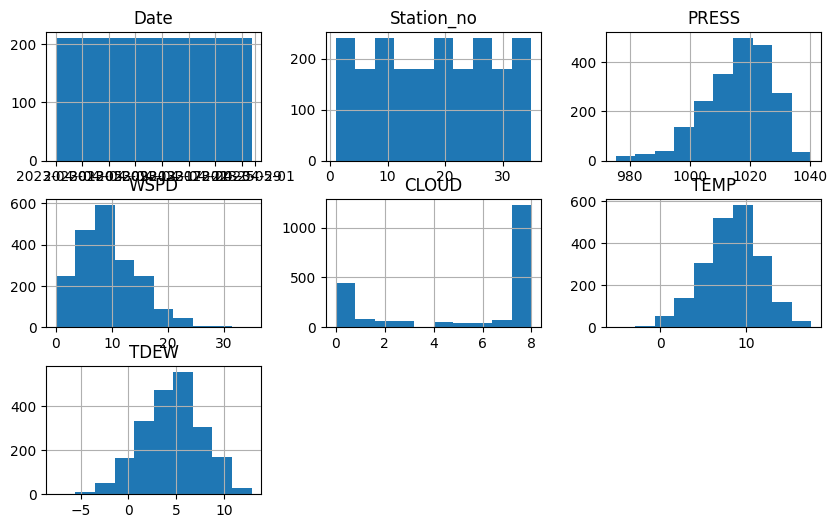

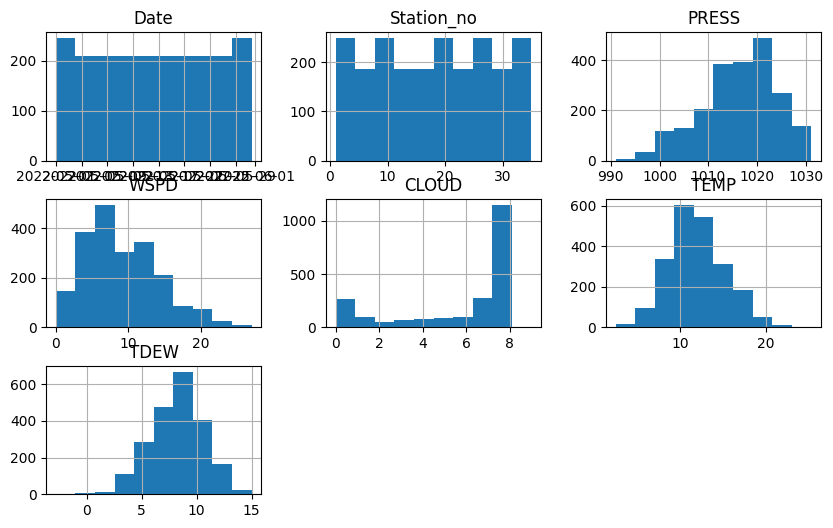

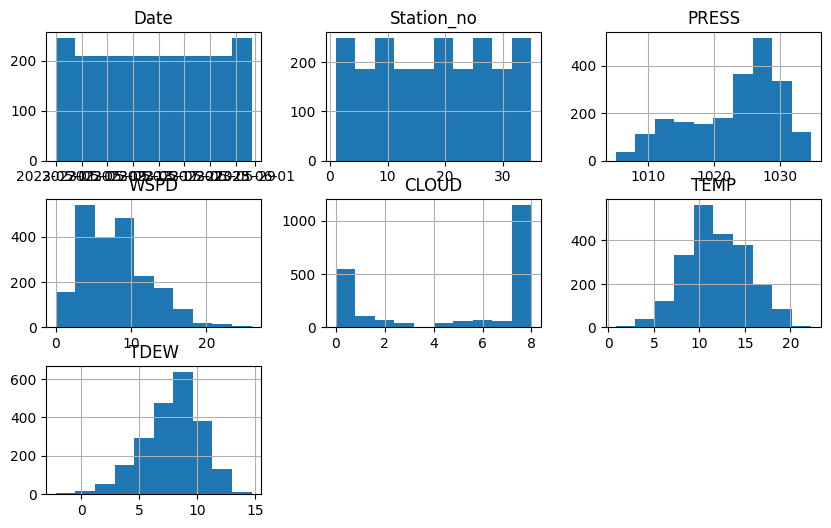

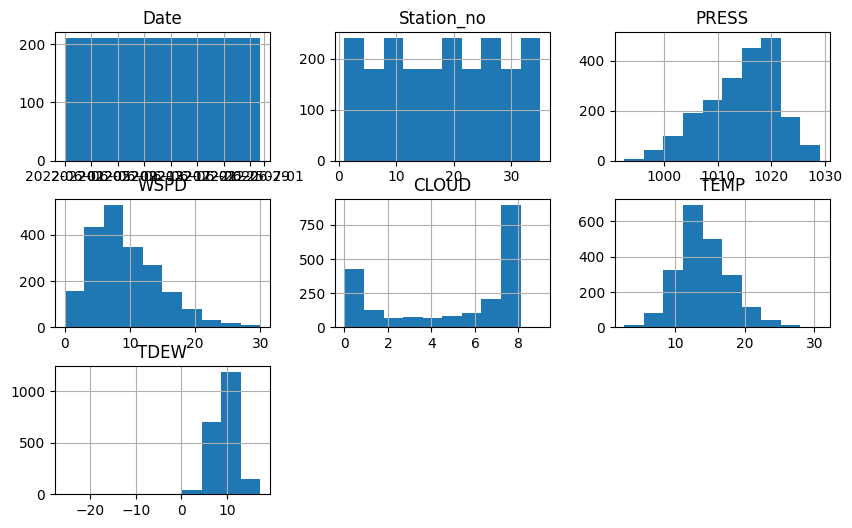

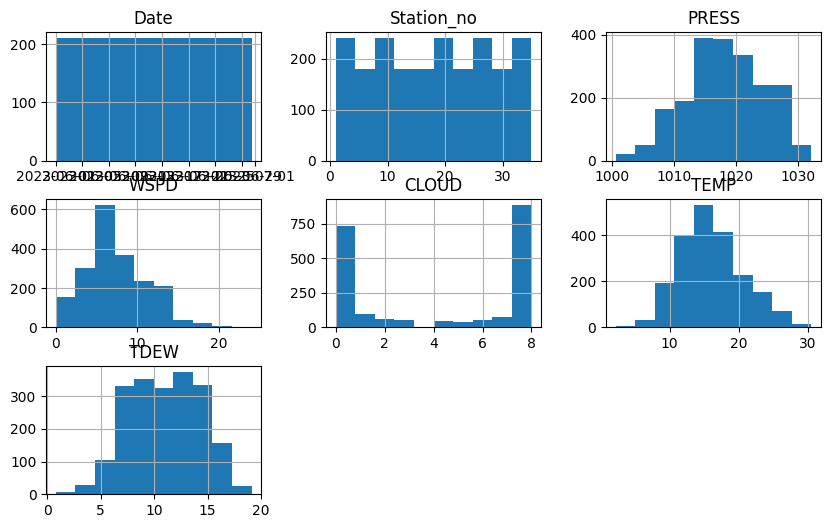

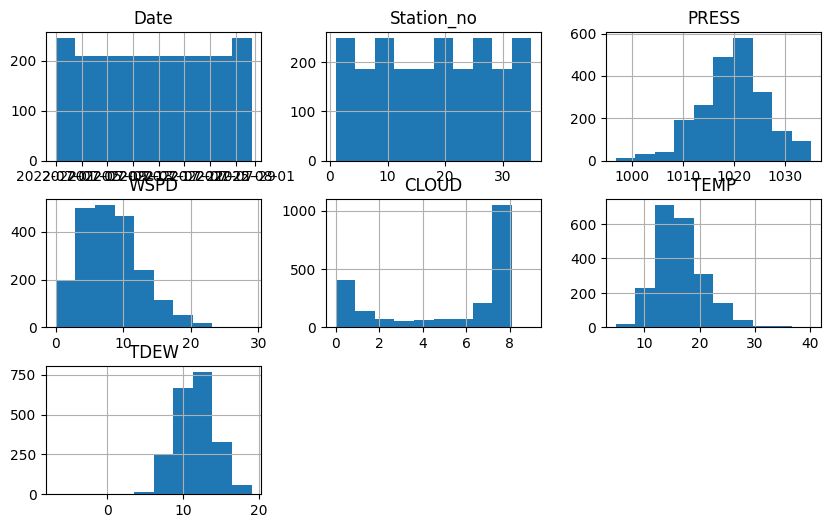

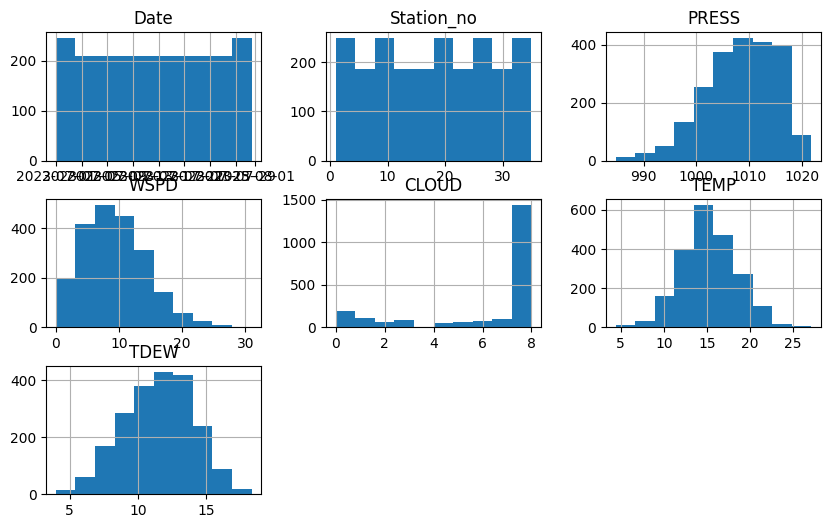

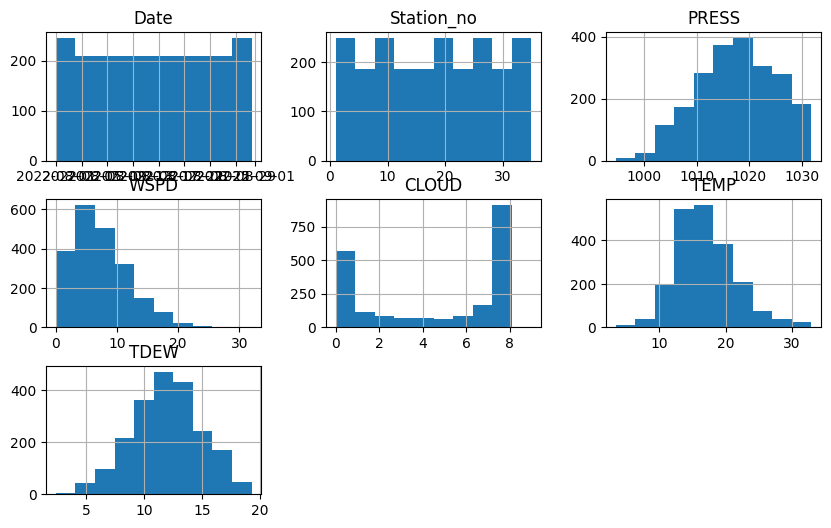

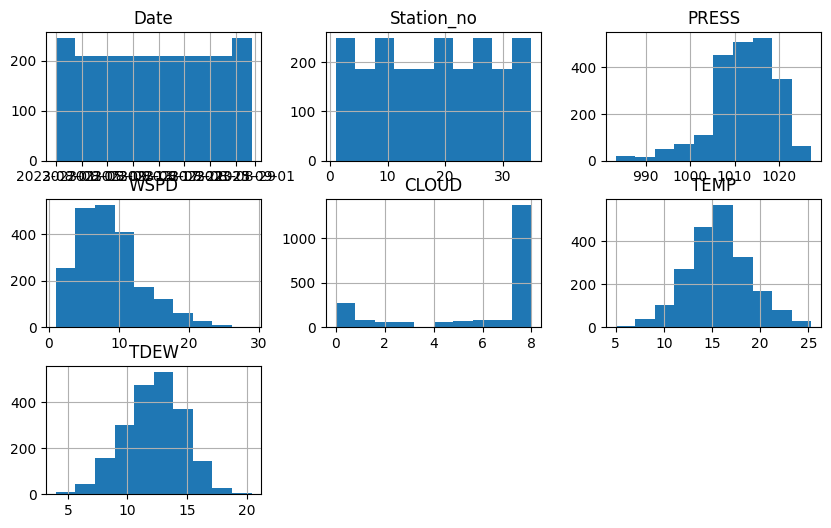

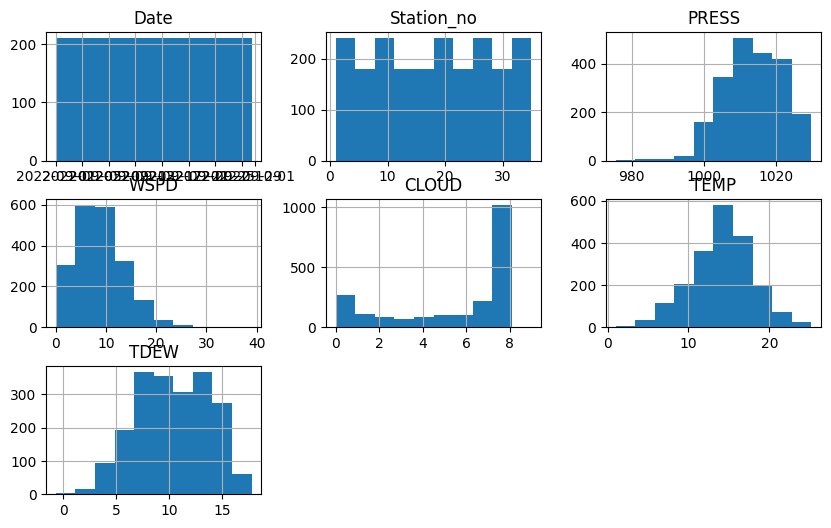

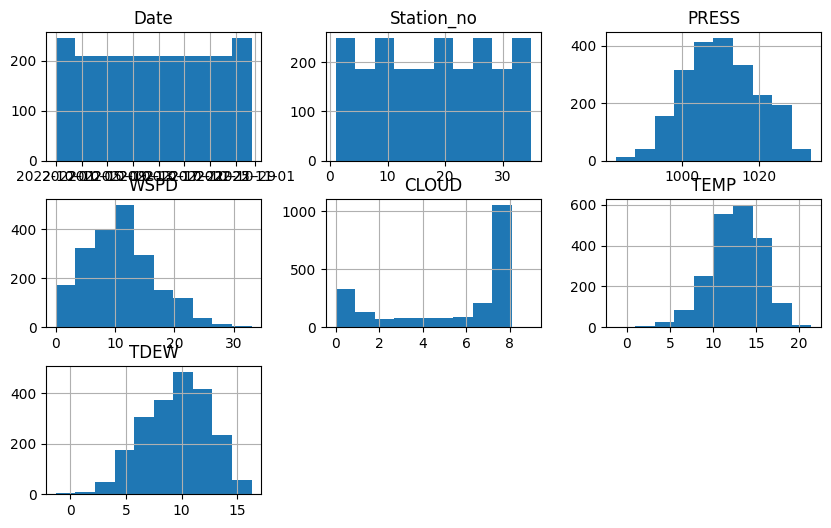

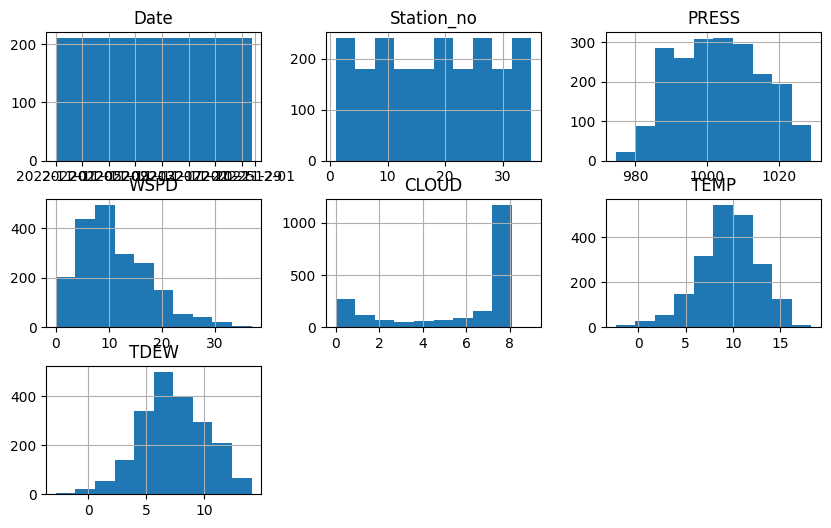

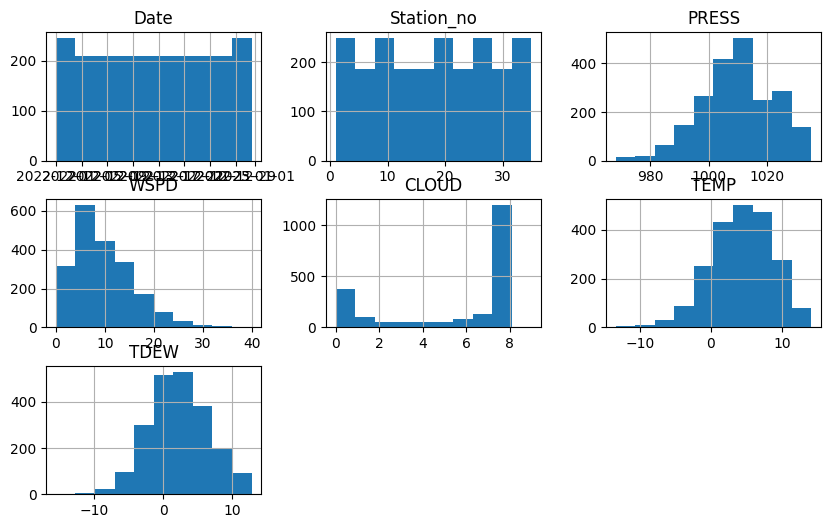

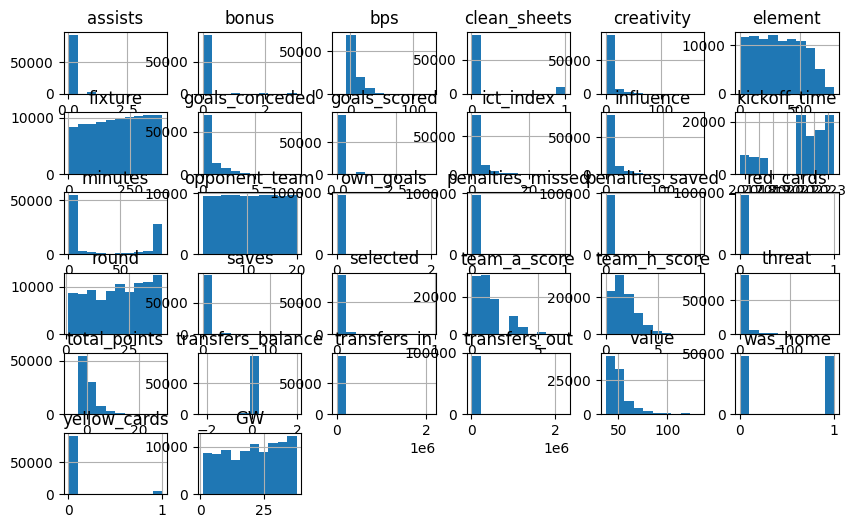

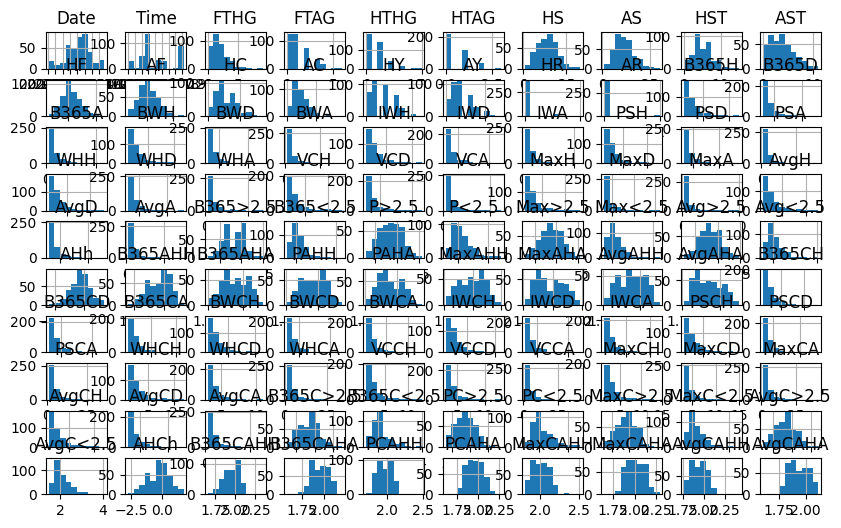

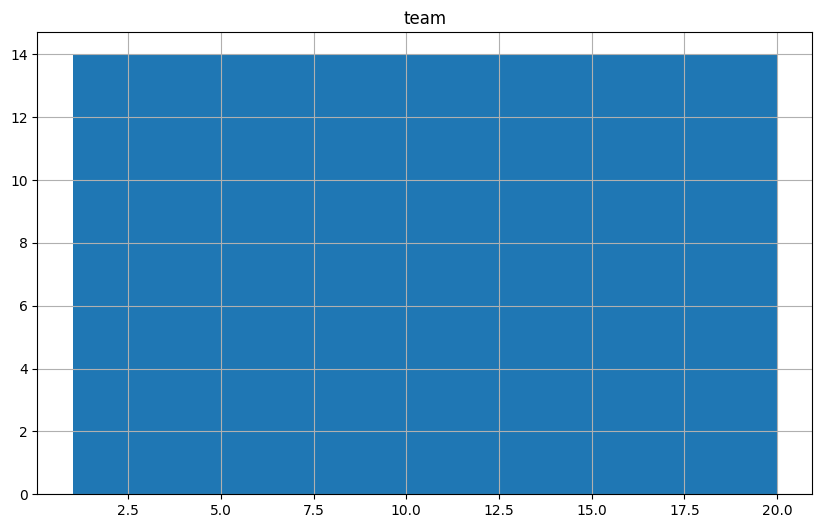

In [15]:
# Descriptive analysis

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
conn = duckdb.connect('../data/formatted_zone/formatted_zone.db')
tables = get_tables(conn)
with open('../data/formatted_zone/descriptive_analysis.txt', mode='w') as f:
    for table_name in tables: 
        f.write(table_name+"\n\n")
        df = conn.sql(f"SELECT * FROM \"{table_name}\";").df()
        f.write(str(df.describe(include='all', datetime_is_numeric=True)))
        f.write('\n')
        f.write(str(df.isna().sum()))
        f.write('\n')
        df.hist(figsize=(10,6))
        plt.savefig(f'../data/formatted_zone/img/{table_name}_profile.png')
conn.close()
pd.reset_option('display.max_columns')
pd.reset_option('display.width')